In [46]:
!pip install wandb
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.layers import Dense, MaxPool2D, Conv2D, Flatten, BatchNormalization, MaxPooling2D, Dropout
import os
from tensorflow.keras import layers
from wandb.keras import WandbCallback
import wandb
from sklearn.metrics import classification_report, confusion_matrix

In [47]:
dataset_path='/content/drive/MyDrive/ dataset'
batch_size = 32
epochs = 10
width = height = 224

In [48]:
data_generator=ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True, 
    brightness_range=[0.9,1.1],
    validation_split=0.1
)
train_data=data_generator.flow_from_directory(
   dataset_path ,
    target_size=(width,height),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    subset='training'

)

val_data=data_generator.flow_from_directory(
    dataset_path,
    target_size=(width,height),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False,
    subset='validation'
)

Found 1228 images belonging to 14 classes.
Found 131 images belonging to 14 classes.


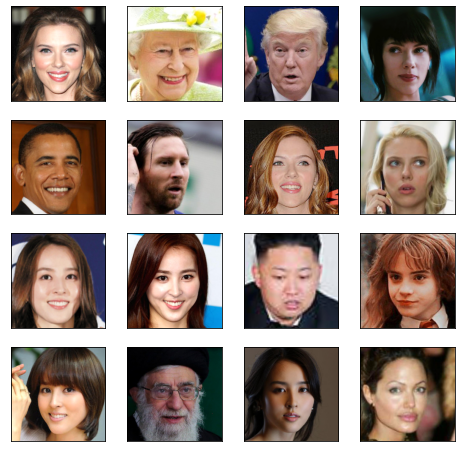

In [49]:
import matplotlib.pyplot as plt

train_images = next(train_data)[0]
plt.figure(figsize = (8,8))
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_images[i] , cmap = plt.cm.binary)

In [50]:
train_data.image_shape

(224, 224, 3)

In [51]:
class MyModel (tf.keras.Model):
  def __init__(self,number_of_classes):
    super().__init__()
    self.base_model=tf.keras.applications.ResNet50V2(input_shape=(width,height,3),include_top=False,weights='imagenet',pooling='max')
    self.flatten=layers.Flatten()
    self.dense128  =layers.Dense(128, activation='relu')
    self.dense32 =layers.Dense(32, activation='relu')
    self.batchnormalization= layers.BatchNormalization()
    self.dense14=layers.Dense(14, activation='sigmoid')
  def call(self,x):
    x=self.base_model(x)
    x=self.flatten(x)
    x=self.dense128(x)
    x=self.dense32(x)
    x=self.batchnormalization(x)
    out_put=self.dense14(x)
    return out_put
    
  

In [52]:
 model=MyModel(14) 

In [53]:
wandb.init(project="face_recognition_expert")

acc,▁▅▇████
epochs,▁▂▃▅▆▇█
loss,█▅▂▂▁▁▁
val_acc,▁▃▆▇█▅█
val_loss,█▃▁▂▁▂▁
acc,0.98697
epochs,6
loss,0.10129
val_acc,0.83969
val_loss,0.68849


In [54]:
loss_function=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer=tf.keras.optimizers.Adam()

In [55]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_acc = tf.keras.metrics.CategoricalAccuracy(name = 'train_acc')

val_loss = tf.keras.metrics.Mean(name='test_loss')
val_acc = tf.keras.metrics.CategoricalAccuracy(name = 'test_acc')

In [56]:
def train_step(images,y):
    with tf.GradientTape() as tape:
        y_pred = model(images,training = True)
        loss = loss_function(y,y_pred)
    gradients = tape.gradient(loss, model.trainable_variables)
    
    optimizer.apply_gradients(zip(gradients,model.trainable_variables))
    train_loss(loss)
    train_acc(y, y_pred)

In [57]:
def val_step(images,y):
  y_pred = model(images,training = False)
  loss = loss_function(y,y_pred)

  val_loss(loss)
  val_acc(y, y_pred)

In [58]:
from tqdm import tqdm
def train():
  epochs=5

  for epoch in range(epochs):
    train_loss.reset_states()
    train_acc.reset_states()
    val_loss.reset_states()
    val_acc.reset_states()
    cnt = 0
    for cnt in tqdm(range(train_data.__len__())):
      images,labels = next(train_data)
      train_step(images,labels)
    for cnt in tqdm(range(val_data.__len__())):
      images,labels = next(val_data)
      val_step(images,labels)


    print('epoch:',epoch+1)
    print('#############')
    print('loss:',train_loss.result())
    print('accuracy:',train_acc.result())
    print('*************************************************')
    print('val loss:',val_loss.result())
    print('val accuracy:',val_acc.result())
    print('--------------------------------------------------')

    wandb.log({'epochs': epoch,
                'loss': train_loss.result(),
                'acc': train_acc.result(), 
                'val_loss': val_loss.result(),
                'val_acc':val_acc.result()})

In [59]:
train()

100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


epoch: 1
#############
loss: tf.Tensor(1.2312354, shape=(), dtype=float32)
accuracy: tf.Tensor(0.6661238, shape=(), dtype=float32)
*************************************************
val loss: tf.Tensor(4.787151, shape=(), dtype=float32)
val accuracy: tf.Tensor(0.13740458, shape=(), dtype=float32)
--------------------------------------------------


100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


epoch: 2
#############
loss: tf.Tensor(0.39420488, shape=(), dtype=float32)
accuracy: tf.Tensor(0.9169381, shape=(), dtype=float32)
*************************************************
val loss: tf.Tensor(2.603907, shape=(), dtype=float32)
val accuracy: tf.Tensor(0.34351146, shape=(), dtype=float32)
--------------------------------------------------


100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


epoch: 3
#############
loss: tf.Tensor(0.31871265, shape=(), dtype=float32)
accuracy: tf.Tensor(0.9340391, shape=(), dtype=float32)
*************************************************
val loss: tf.Tensor(0.9660681, shape=(), dtype=float32)
val accuracy: tf.Tensor(0.77862597, shape=(), dtype=float32)
--------------------------------------------------


100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


epoch: 4
#############
loss: tf.Tensor(0.18353365, shape=(), dtype=float32)
accuracy: tf.Tensor(0.96824104, shape=(), dtype=float32)
*************************************************
val loss: tf.Tensor(0.63204706, shape=(), dtype=float32)
val accuracy: tf.Tensor(0.77862597, shape=(), dtype=float32)
--------------------------------------------------


100%|██████████| 5/5 [00:02<00:00,  1.69it/s]

epoch: 5
#############
loss: tf.Tensor(0.11987324, shape=(), dtype=float32)
accuracy: tf.Tensor(0.98045605, shape=(), dtype=float32)
*************************************************
val loss: tf.Tensor(1.0042149, shape=(), dtype=float32)
val accuracy: tf.Tensor(0.8549618, shape=(), dtype=float32)
--------------------------------------------------


In [79]:
!pip install retina-face
from retinaface import RetinaFace
import cv2
import matplotlib.pyplot as plt

def predict(image_path):
    faces = RetinaFace.extract_faces(img_path= image_path, align= True)
    image = faces[0]
    image = cv2.resize(image, (width, height))
    plt.imshow(image)
    image = image / 255.0
    image = np.expand_dims(image, axis= 0)
    y_pred = model(image,training=False)
    res = np.argmax(y_pred)
    if res == 3:
        print('behnam bani')
    else:
        print('no ')


behnam bani


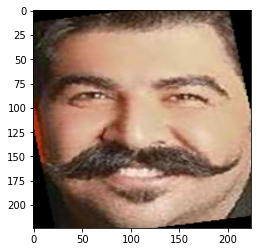

In [81]:
predict('8.jpg')

In [ ]:
model.save_weights('model.h5')